HSE, Applied Time Series Forecasitng , Winter 2024-2025

<font color="green"> Lesson #6: Using exogenous Variables in ARIMA Models </font>

<span style="color:black; font-size: 12pt"></span>

Alexey Romanenko,
<font color="blue">alexromsput@gmail.com</font>

**Key words:**
    - exogenous variables, (S)ARIMA(X), autocorrelcation function,  partial autocorrelation function

**Your feedback:**  please provide you feedback  <a href="https://forms.gle/bEV5iwmTqdM9rUoy8"> here </a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import stattools
from copy import deepcopy

import plotly.graph_objects as go
import plotly.express as px

# don't forget to upload utils file to the colab session
from utils import qualityMAPE, qualityRMSE
# import warnings, pylab
# warnings.filterwarnings('ignore')

In [2]:
def draw_arima_forecast(ts, arima_model, start_dt=0, end_dt=-1):
  predict = arima_model.get_prediction()
  forecast = pd.DataFrame(predict.predicted_mean).rename(columns = {'predicted_mean':'static_forecast'})
  forecast_ci = predict.conf_int().rename(columns = {'lower wage_boxcox':'l_ci_st',	'upper wage_boxcox':'u_ci_st'}) # confidence interval

  #  Dynamic predictions
  predict_dy = arima_model.get_prediction(dynamic=start_dt)
  forecast_dy = pd.DataFrame(predict_dy.predicted_mean).rename(columns = {'predicted_mean':'dynamic_forecast'})
  forecast_dy_ci = predict_dy.conf_int().rename(columns = {'lower wage_boxcox':'l_ci_dy',	'upper wage_boxcox':'u_ci_dy'}) # confidence interval

  if start_dt ==0:
    start_dt= ts.index.min()

  if end_dt == -1:
    end_dt = ts_wage_boxcox.index.max()

  # Plot data points and predictions
  fig = ts.loc[start_dt:].merge(
      forecast[start_dt:end_dt],
        how = 'left', left_index = True, right_index = True
        ).merge(
            forecast_dy[start_dt:],
            how = 'left', left_index = True, right_index = True
        ).merge(
          forecast_ci,
          how = 'left', left_index = True, right_index = True
        ).merge(
          forecast_dy_ci,
          how = 'left', left_index = True, right_index = True
        ).plot().update_layout(height=350, width=1300).show()

  return fig

# ARIMA with exogenous Variables
**Questions**
  * How to provide independent variables into ARIMA?
  * Should Seasonal Differencing transformation be applied to exogenous variables  if it should to target time series?
    - Usually, Yes
  * Should Trend Differencing transformation be applied to exogenous variables  if it should to target time series?
    - Usually, Yes
  * Should BoxCox transformation be applied to exogenous variables if it should to target time series?
   - Usually, No

Time Series model with exogenous variable:

* Lets denote: ${\bf BoxCox_{\lambda}} (y_t) = z_t$
* Idea to include exogenous variables
$$z_t = u_t + \sum_{k=1}^K \omega_k\cdot X^k_t$$
$X^k_t~-$ exogenous variable time series,

* classic form:
$$\color{red}{\underbrace{\bf(1-B)^d(1-B^s)^D}\limits_{I}}u_t = \underbrace{\sum_{i=1}^{p} \alpha_iu_{t-i}}\limits_{AR}+\underbrace{\sum_{j=1}^{q} \beta_j\varepsilon_{t-j}}\limits_{MA}+\varepsilon_t$$

* or in canonical form:

$$\underbrace{\phi\left({\bf B}\right)}\limits_{AR}\color{red}{\underbrace{\bf(1-B)^d(1-B^s)^D}\limits_{I}}\left(z_t-\sum_{k=1}^K \omega_k\cdot X^k_t\right) = \underbrace{\theta\left(\bf B\right)}\limits_{MA}\varepsilon_t.$$

* $\varepsilon_t$- random variable from $N(0, \sigma^2)$, $E\varepsilon_t=0, ~E\varepsilon_i\varepsilon_j=0$

# Using exogenous variables in ARIMA models

## Energy Forecasting

In [3]:
import requests
from io import StringIO

url = 'https://raw.githubusercontent.com/aromanenko/ATSF/main/data/energy_consumption.csv'
response = requests.get(url, verify=True)

df = pd.read_csv(StringIO(response.text), parse_dates=['Date'])
ts = df[df.id == 9].drop(columns='id').set_index('Date').iloc[:-14]

ts.head(10)


,EnergyConsumption,Temp1,Temp2,Temp3,Temp4,Temp5,Temp6,Temp7,Saturday,Sunday,Temp1_South_Less,Temp2_South_Less,Temp3_South_Less,Temp4_South_Less,Temp1_South_Gr,Temp2_South_Gr,Temp3_South_Gr,Temp4_South_Gr
Date,,,,,,,,,,,,,,,,,,
2010-01-01,74143.846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,11.8,10.0,9.4,5.0,22.5,22.5,22.5,22.5
2010-01-02,75426.434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,12.0,14.4,11.6,8.5,22.5,22.5,22.5,22.5
2010-01-03,78407.835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,4.5,9.3,5.0,2.0,22.5,22.5,22.5,22.5
2010-01-04,81702.952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,-1.6,6.0,-0.9,-7.0,22.5,22.5,22.5,22.5
2010-01-05,85896.716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,-1.0,5.0,-2.1,-9.0,22.5,22.5,22.5,22.5
2010-01-06,86383.843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,3.1,5.6,0.4,-2.3,22.5,22.5,22.5,22.5
2010-01-07,81673.359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,9.7,11.5,4.4,-2.0,22.5,22.5,22.5,22.5
2010-01-08,81700.228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,9.5,13.3,7.8,1.5,22.5,22.5,22.5,22.5
2010-01-09,81149.883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,9.9,12.6,7.5,3.0,22.5,22.5,22.5,22.5


As one can see there are no meaningful values for regressors Temp1, ..., Temp7, so we can drop them.

In [4]:
ts = ts.drop(columns=[f'Temp{i+1}' for i in range(7)], errors='ignore')
ts.describe()

,EnergyConsumption,Saturday,Sunday,Temp1_South_Less,Temp2_South_Less,Temp3_South_Less,Temp4_South_Less,Temp1_South_Gr,Temp2_South_Gr,Temp3_South_Gr,Temp4_South_Gr
count,1959.000000,1959.000000,1959.000000,1959.000000,1959.000000,1959.000000,1959.000000,1959.000000,1959.000000,1959.000000,1959.000000
mean,96976.405258,0.139867,0.184788,12.031904,14.643185,12.239459,9.823328,22.898673,23.025881,23.018173,23.112813
std,19507.341764,0.346938,0.388225,8.426554,6.406297,8.484955,10.579540,1.189977,1.309972,1.372347,1.651379
min,58956.227000,0.000000,0.000000,-17.000000,-2.500000,-14.400000,-23.500000,22.500000,22.500000,22.500000,22.500000
25%,81142.468000,0.000000,0.000000,5.800000,9.300000,5.500000,1.500000,22.500000,22.500000,22.500000,22.500000
50%,95687.916000,0.000000,0.000000,12.000000,14.500000,12.300000,10.000000,22.500000,22.500000,22.500000,22.500000
75%,112212.540000,0.000000,0.000000,20.000000,21.500000,21.000000,21.000000,22.500000,22.500000,22.500000,22.500000
max,153436.189000,1.000000,1.000000,22.500000,22.500000,22.500000,22.500000,30.300000,30.000000,30.400000,33.000000


In [5]:
# Plot the whole time period
ts['EnergyConsumption'].plot().update_layout(height=350, width=1300).show()

In [6]:
# Plot 6 months in order to see week seasonality
ts['EnergyConsumption']['2011-01':'2011-07'].plot().update_layout(height=350, width=1300).show()

In [7]:
ts.columns[3:]

Index(['Temp1_South_Less', 'Temp2_South_Less', 'Temp3_South_Less',
       'Temp4_South_Less', 'Temp1_South_Gr', 'Temp2_South_Gr',
       'Temp3_South_Gr', 'Temp4_South_Gr'],
      dtype='object')

In [8]:
# Plot the TS together with independent variables
ts_to_plot = ts.loc['2011-01':'2011-12']
# Driver analysis
# create cross-series plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=ts_to_plot['EnergyConsumption'].index,
                        y=ts_to_plot['EnergyConsumption']
                        , name="EnergyConsumption"))

fig.add_trace(go.Scatter(x=ts_to_plot['EnergyConsumption'].index,
                        y=ts_to_plot[['Sunday', 'Saturday']].max(axis=1).replace(0, np.NaN)
                        , name="Saturday and Sunday", yaxis="y2"))
fig.add_trace(
    go.Scatter(x=ts_to_plot['EnergyConsumption'].index,
                        y=ts_to_plot['Temp1_South_Less']
                        , name="Temp", yaxis="y3"))
fig.add_trace(
    go.Scatter(x=ts_to_plot['EnergyConsumption'].index,
                        y=ts_to_plot['Temp2_South_Less']
                        , name="Temp", yaxis="y3"))

fig.update_layout(
    xaxis=dict(domain=[0.1, 0.95]),
    yaxis=dict(
        title="EnergyConsump",
    ),
    yaxis2=dict(
        title="Holidays",
        overlaying="y",
        side="right",
    ),
    yaxis3=dict(title="Temp", anchor="free", overlaying="y", autoshift=True),
)

fig.update_layout(height=500, width=1300).show()

One can see from the plots that TS be described as follows:
* there is increasing trend,
* there are two types of seasonality: weekly (period 7) and yearly (period 365),
* it seems there is no variance instability.

Thus, in order to make the TS stationary
* we need trend differentiation with shift 1,
* we need two seasonal differentiations with shifts 7 and 365,
* we don't need Box-Cox transformation.
<font color = 'red'> Regarding Box-Cox transformation it is not so obvious</font>

# Fit ARIMA Model

**I. Build ARIMA forecast manually **

You should follow the next scheme:

 * 0) split the ts to two parts: first 80% of timestamps (ts1) and the last 20% of timestamps (ts2)   
 * 1) apply transformation to make the ts1 stationary;
 * 2) define exogenous variables and apply the transformations to them, if needed
 * 3) train simple ARIMA (0, 0, 0) with exogenous variables only, endog = 1) exog = 2);
 * 4) plot ACF/PACF for resifuals of the simple ARIMA(0, 0, 0) in order to understand which $p, P, q, Q$ can be used; define set of candidate parameters for ARMA (for the train TS);
 * 5) select the best parameters of the ARIMA models iteratively:
    * While there are significant ACF/PACF lags and ARIMA can be trained
      - change only one of 6 ARIMA parameters (p, d, q, P, D, Q)
      - compare the new model with the previous best model based on  AIC|BIC|HQIC
      - plot ACF/PACF of the best model

  **Note**: there is no goal to minimize AIC|BIC|HQIC, the goal is to exclude all significant autocorrelations from ACF/PACF.

* 6) Check  the best model residuals for
    - unbiasedness,
    - stationarity
    - non-autocorrelation
    - white noise hypothesis

    If all tests fail you need to review your choice.
* 7) Run analysis of the regression coefficients
    
    - if there are some insignificant regressors that can be eliminated, please exclude them from the model.

* 8) build forecast for the ts2 (you need to transform exogenous variables if you applied Box-Cox tranformations in step 1); plot this forecast on the same plot with original ts2 data
* 9) Calculate loss MAPE of your forecast. Does the forecast look appropriate?

In [9]:
ts

,EnergyConsumption,Saturday,Sunday,Temp1_South_Less,Temp2_South_Less,Temp3_South_Less,Temp4_South_Less,Temp1_South_Gr,Temp2_South_Gr,Temp3_South_Gr,Temp4_South_Gr
Date,,,,,,,,,,,
2010-01-01,74143.846,0.0,1.0,11.8,10.0,9.4,5.0,22.5,22.5,22.5,22.5
2010-01-02,75426.434,1.0,0.0,12.0,14.4,11.6,8.5,22.5,22.5,22.5,22.5
2010-01-03,78407.835,0.0,1.0,4.5,9.3,5.0,2.0,22.5,22.5,22.5,22.5
2010-01-04,81702.952,0.0,1.0,-1.6,6.0,-0.9,-7.0,22.5,22.5,22.5,22.5
2010-01-05,85896.716,0.0,1.0,-1.0,5.0,-2.1,-9.0,22.5,22.5,22.5,22.5
...,...,...,...,...,...,...,...,...,...,...,...
2015-05-09,97324.684,1.0,0.0,13.5,14.3,14.7,14.2,22.5,22.5,22.5,22.5
2015-05-10,96028.648,0.0,1.0,13.0,14.5,15.0,14.5,22.5,22.5,22.5,22.5
2015-05-11,96883.560,0.0,1.0,12.0,13.5,14.5,15.0,22.5,22.5,22.5,22.5


In [10]:
# Split TS 80%-20%
split_idx = int(len(ts) * 0.8)
ts1 = ts.iloc[:split_idx]
ts2 = ts.iloc[split_idx:]

Let's apply required transformations to the TS manually in order to make it stationary.

In [11]:
# seasonal differencing 1
s = 365
ts_sdiff = (ts - ts.shift(s)).iloc[s:]
ts_sdiff['EnergyConsumption']['2012':'2013'].plot().update_layout(height=350, width=1300).show()

In [12]:
# seasonal differencing 2
s = 7
ts_ssdiff = (ts_sdiff - ts_sdiff.shift(s)).iloc[s:]
ts_ssdiff['EnergyConsumption']['2012':'2013'].plot().update_layout(height=350, width=1300).show()

In [13]:
# trend differencing
ts_ssdiff_tdiff = (ts_ssdiff - ts_ssdiff.shift(1)).iloc[1:]
ts_ssdiff_tdiff['EnergyConsumption']['2012-01':'2013-07'].plot().update_layout(height=350, width=1300).show()

In [ ]:
# Augmented Dickey-Fuller unit root test:
# H0: ts is not stationary (https://www.statisticshowto.com/adf-augmented-dickey-fuller-test/)
df_stat = stattools.adfuller(ts_ssdiff_tdiff['EnergyConsumption'])
print('The Augmented Dickey-Fuller test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ncritical values: %s' %
      (df_stat[0], df_stat[1], df_stat[2], df_stat[4]))

The Augmented Dickey-Fuller test statistic -14.222468, 
pvalue: 0.00 
maximal Lag: 20 
critical values: {'1%': -3.4345353407734733, '5%': -2.86338857621683, '10%': -2.567754150088293}


In [ ]:
# Kwiatkowski–Phillips–Schmidt–Shin
# H0: ts is stationary (https://www.statisticshowto.com/kpss-test/)
kpss_stat= stattools.kpss(ts_ssdiff_tdiff['EnergyConsumption'])
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' %
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.002116, 
pvalue: 0.10 
maximal Lag: 3 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


<ipython-input-17-a0d9a12c0bed>:3: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




According to both Dickey-Fuller and KPSS tests the trasformed TS is stationary.

In [14]:
def plot_acf_pacf(model, lags=365):
    fig = plt.figure(figsize=[25,5])
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(model.resid.values.squeeze(), lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(model.resid.values.squeeze(), lags=lags, ax=ax2)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                               SARIMAX Results                                
Dep. Variable:      EnergyConsumption   No. Observations:                 1194
Model:                          ARIMA   Log Likelihood              -15189.191
Date:                Wed, 26 Feb 2025   AIC                          30402.382
Time:                        00:50:26   BIC                          30463.402
Sample:                    01-09-2011   HQIC                         30425.373
                         - 04-16-2014                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2650   1.35e+05   1.96e-06      1.000   -2.65e+05    2.65e+05
Saturday         -1607.9373   8.49e+05     -0.002      0.998   -1.67e+06    1.66e+06
Sunday           -6328.6835 

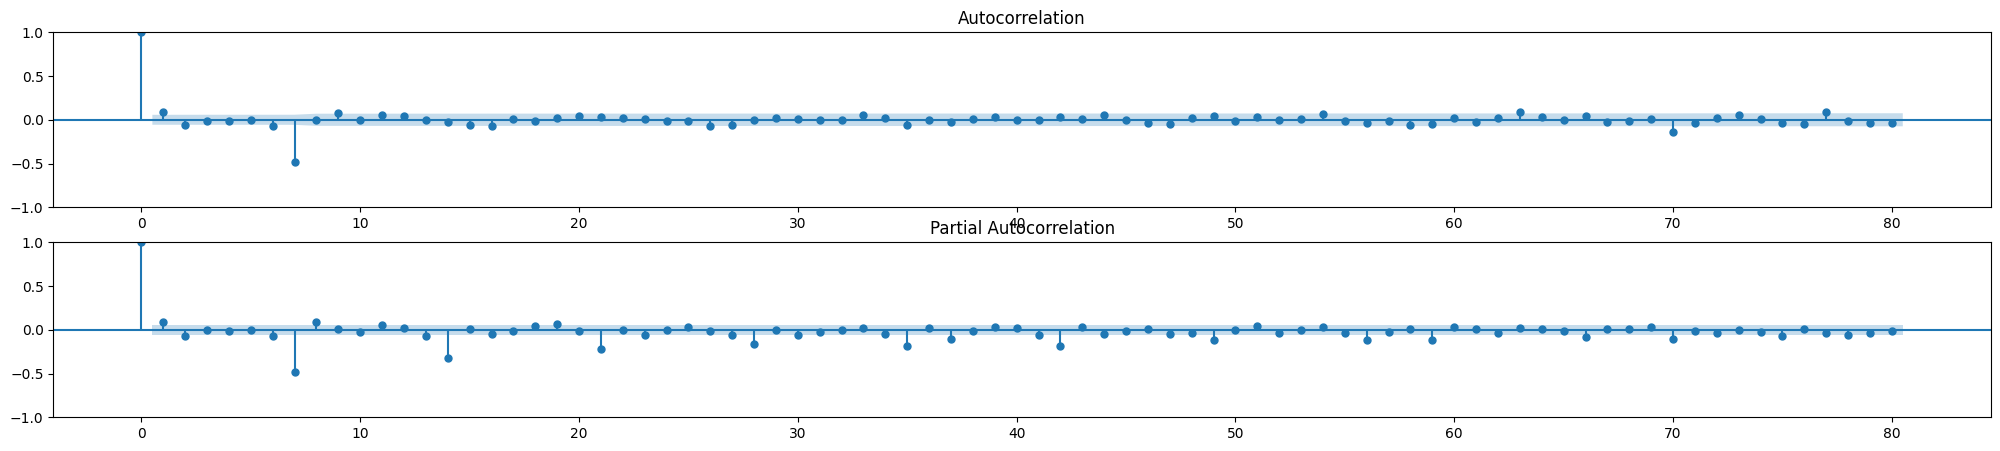

In [15]:
# Step 0: train ARIMA(0,0,0)
ts_ssdiff_tdiff_1 = ts_ssdiff_tdiff[:-len(ts2)]
endog = ts_ssdiff_tdiff_1['EnergyConsumption']
exogs = ts_ssdiff_tdiff_1.drop(columns=['EnergyConsumption'])
arima_order_000 = sm.tsa.ARIMA(endog=endog, order=[0,0,0], exog=exogs).fit()
print(arima_order_000.summary())
plot_acf_pacf(arima_order_000, lags=80)

Analysis of ACF and PACF for ARIMA(0,0,0) suggests the following parameter candidate values:
* q = {0, 1,2,6}
* Q = {0, 1}
* p = {0, 1,2,6}
* P = {0, 1,2,3,...}

Let's move step-by-step and start with changing only one parameter.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                 SARIMAX Results                                 
Dep. Variable:         EnergyConsumption   No. Observations:                 1194
Model:             SARIMAX(0, 0, [1], 7)   Log Likelihood              -11180.347
Date:                   Wed, 26 Feb 2025   AIC                          22384.695
Time:                           01:29:28   BIC                          22445.715
Sample:                       01-09-2011   HQIC                         22407.686
                            - 04-16-2014                                         
Covariance Type:                     opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Saturday         -1616.9404    943.577     -1.714      0.087   -3466.318     232.437
Sunday           -6316.2911    261.369    -24.166      0.000   -6828.565   -5804.017
Temp

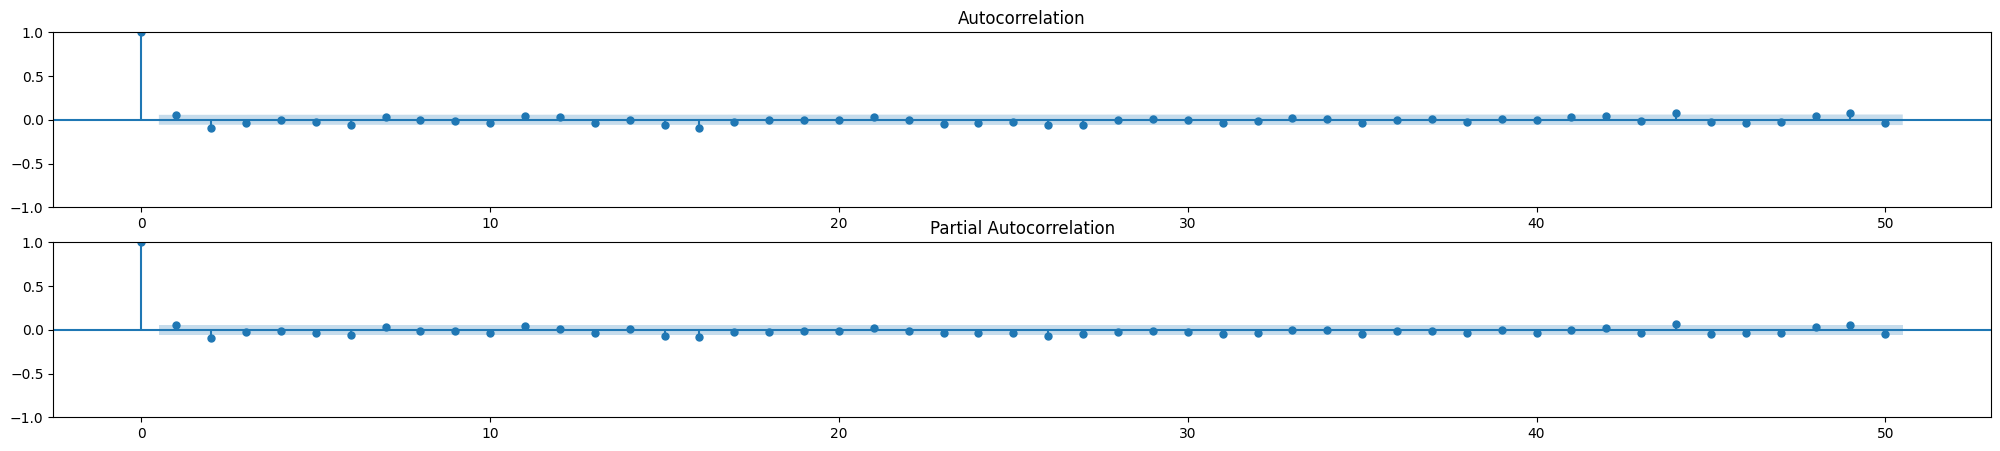

In [16]:
# Step 1: train ARIMA(0,0,0)x(0,0,1,7)
arima_order_000_001 = sm.tsa.SARIMAX(endog=endog, order=[0,0,0], seasonal_order=[0,0,1,7], exog=exogs).fit()
print(arima_order_000_001.summary())
plot_acf_pacf(arima_order_000_001, lags=50)

All information critera for ARIMA(0,0,0)x(0,0,1,7) model are really smaller than for the previous ARIMA(0,0,0) model. This happens apparently due to excluding many correlations at the cost of increasing model complexity very slightly.

Now, seasonality with period 7 seems to be excluded from ACF / PACF. Let's exclude lags 1, 2 and 6.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                          SARIMAX Results                                          
Dep. Variable:                           EnergyConsumption   No. Observations:                 1194
Model:             SARIMAX([1, 2, 6], 0, 0)x(0, 0, [1], 7)   Log Likelihood              -11171.140
Date:                                     Wed, 26 Feb 2025   AIC                          22372.279
Time:                                             01:29:32   BIC                          22448.555
Sample:                                         01-09-2011   HQIC                         22401.019
                                              - 04-16-2014                                         
Covariance Type:                                       opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Saturday         -1617.6543   

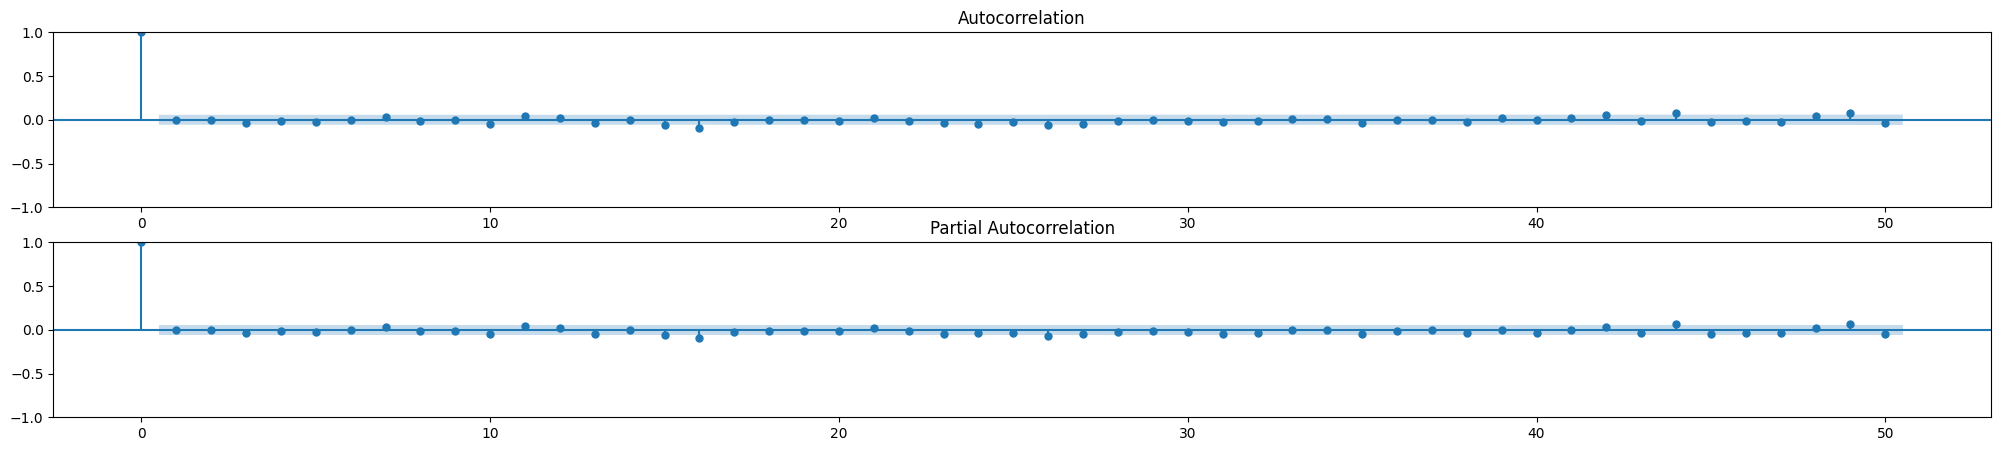

In [17]:
# Step 2: train ARIMA((6,0,0)x(0,0,1,7)
# We use only lags 1, 2 and 6 in order to make ARIMA a bit simpler
arima_order_600_001 = sm.tsa.SARIMAX(endog=endog, order=[(1,2,6),0,0], seasonal_order=[0,0,1,7], exog=exogs).fit()
print(arima_order_600_001.summary())
plot_acf_pacf(arima_order_600_001, lags=50)

AIC and HQIC for ARIMA(6,0,0)x(0,0,1,7) are a bit smaller than for ARIMA(0,0,0)x(0,0,1,7) whereas BIC is slighly bigger. Again, this happens apparently due to excluding more significant correlations at the cost of increasing model complexity very slightly.

There are still some significant lags on ACF / PACF plots. Let's add AR component for seasonality.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                          SARIMAX Results                                          
Dep. Variable:                           EnergyConsumption   No. Observations:                 1194
Model:             SARIMAX([1, 2, 6], 0, 0)x(1, 0, [1], 7)   Log Likelihood              -11170.642
Date:                                     Wed, 26 Feb 2025   AIC                          22373.284
Time:                                             01:29:39   BIC                          22454.645
Sample:                                         01-09-2011   HQIC                         22403.940
                                              - 04-16-2014                                         
Covariance Type:                                       opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Saturday         -1617.2293   

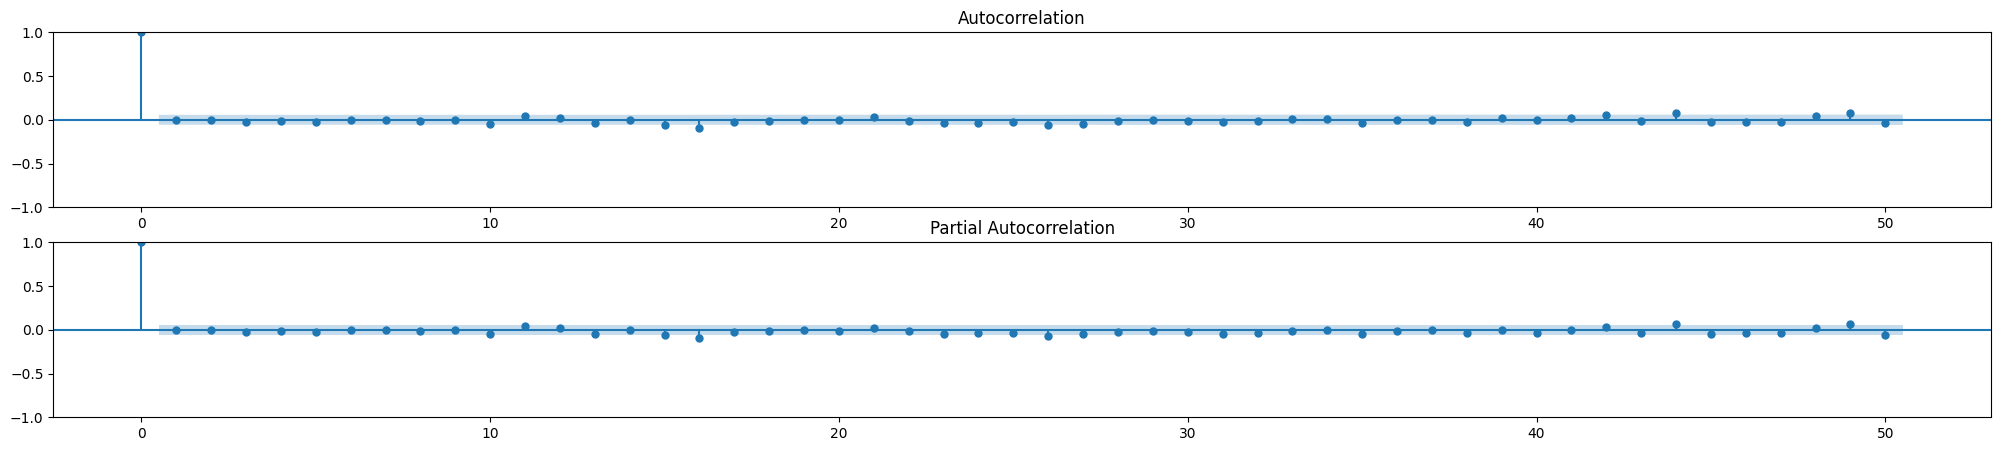

In [18]:
# Step 3: train ARIMA(6,0,0)x(1,0,1,7)
arima_order_600_101 = sm.tsa.SARIMAX(endog=endog, order=[(1,2,6),0,0], seasonal_order=[1,0,1,7], exog=exogs).fit()
print(arima_order_600_101.summary())
plot_acf_pacf(arima_order_600_101, lags=50)

All information criteria for this new model are greater for the new model. It happens probably due to higher model complexity which overweights small improvement in correlations.

Since the correlation has not gone completely yet, let's add MA component with lags 1 and 6.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                            SARIMAX Results                                             
Dep. Variable:                                EnergyConsumption   No. Observations:                 1194
Model:             SARIMAX([1, 2, 6], 0, [1, 6])x(1, 0, [1], 7)   Log Likelihood              -11267.035
Date:                                          Wed, 26 Feb 2025   AIC                          22570.070
Time:                                                  01:29:49   BIC                          22661.601
Sample:                                              01-09-2011   HQIC                         22604.557
                                                   - 04-16-2014                                         
Covariance Type:                                            opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

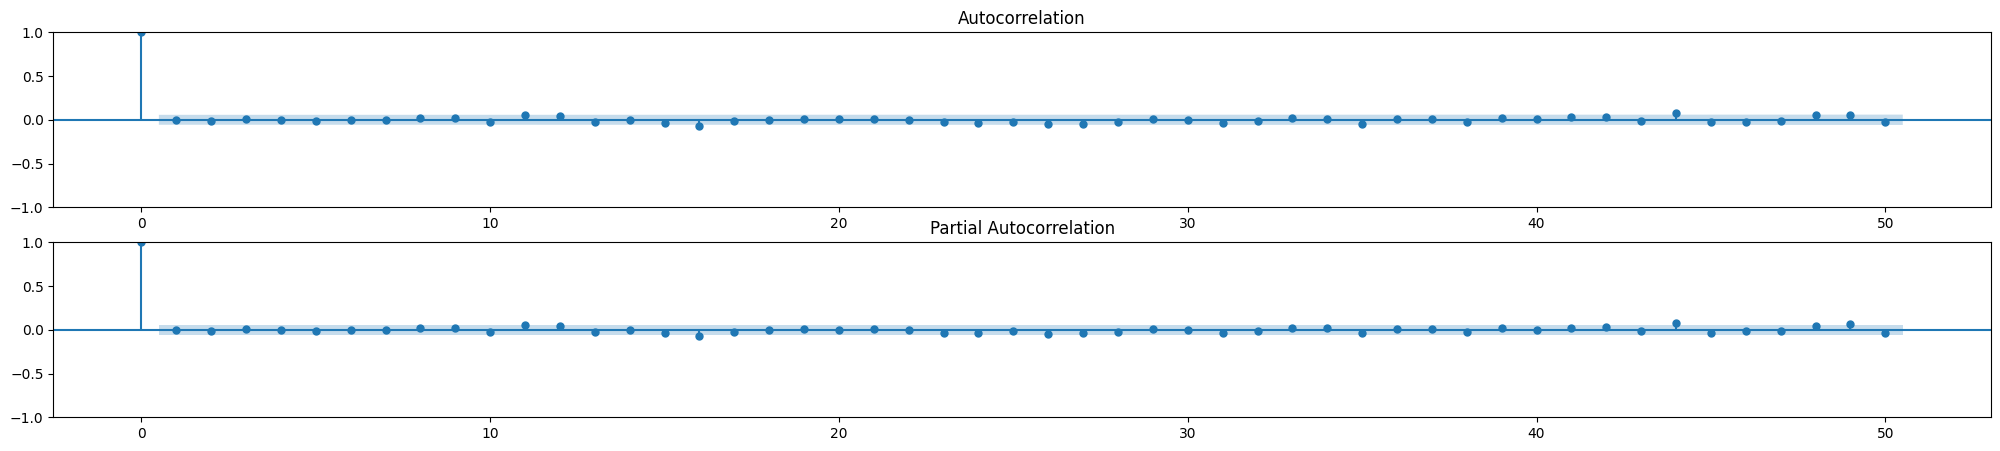

In [19]:
# Step 4: train ARIMA(6,0,6)x(1,0,1,7)
arima_order_606_101 = sm.tsa.SARIMAX(endog=endog, order=[(1,2,6),0,(1,6)], seasonal_order=[1,0,1,7], exog=exogs).fit()
print(arima_order_606_101.summary())
plot_acf_pacf(arima_order_606_101, lags=50)

The last model ARIMA(6,0,6)x(1,0,1,7) seems to be the best one in terms of excluding / reducing significant correlations on ACF / PACF plots. On the other hand, all information criteria have bigger (i.e. worse) values apparently due to the higher model complexity.

In [20]:
arima_best = arima_order_606_101

Analyse the residuals

In [21]:
# plot residuals
arima_best.resid.plot().update_layout(height=350, width=1300).show()

In [22]:
# Augmented Dickey-Fuller unit root test:
# H0: ts is not stationary
df_stat = stattools.adfuller(arima_best.resid.values)
print('The Augmented Dickey-Fuller test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ncritical values: %s' %
      (df_stat[0], df_stat[1], df_stat[2], df_stat[4]))

The Augmented Dickey-Fuller test statistic -34.492450, 
pvalue: 0.00 
maximal Lag: 0 
critical values: {'1%': -3.43584323237365, '5%': -2.863965714307509, '10%': -2.5680614958661483}


In [24]:
# Kwiatkowski–Phillips–Schmidt–Shin
# H0: ts is stationary
kpss_stat= stattools.kpss(arima_best.resid.values)
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' %
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.154273, 
pvalue: 0.10 
maximal Lag: 1 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/var/folders/hr/f_2s6h151nd1d3z3jbvw4ngm0000gp/T/ipykernel_42019/793690813.py:3: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




Both tests show that the residuals are stationary.

In [25]:
# Ljung-Box test
# H0: residuals are not autocorrelated (https://www.statisticshowto.com/ljung-box-test/)
nlags = 80
pd.DataFrame({
    'lags': range(nlags),
    'pvalue': sm.stats.diagnostic.acorr_ljungbox(arima_best.resid.values, lags=nlags)['lb_pvalue'],
    'critial': np.array([0.05]*nlags)
}).set_index('lags').plot().update_layout(height=350, width=1300).show()

In [26]:
# Durbin-Watson statistic
# H0: residuals are not autocorrelated (https://www.statisticshowto.com/durbin-watson-test-coefficient/)
# Must be close or equal to 2
sm.stats.durbin_watson(arima_best.resid.values)

1.998624544715292

Ljung-Box test is not significant for first 50 lags so we can consider the residuals to be not autocorrelated. It is also confirmed by Durbin-Watson statistic which is very close to 2.

In [27]:
# Wilcoxon test
# H0: residuals are unbiased (https://www.statisticshowto.com/wilcoxon-signed-rank-test)
stat, p = stats.wilcoxon(arima_best.resid.values)
print('Statistic: %f\npvalue: %.2f' %(stat, p))

Statistic: 354128.000000
pvalue: 0.83


Wilcoxon test is not significant so we can consider the residuals to be unbiased.

NormaltestResult(statistic=227.30553863641674, pvalue=4.377533034123094e-50)


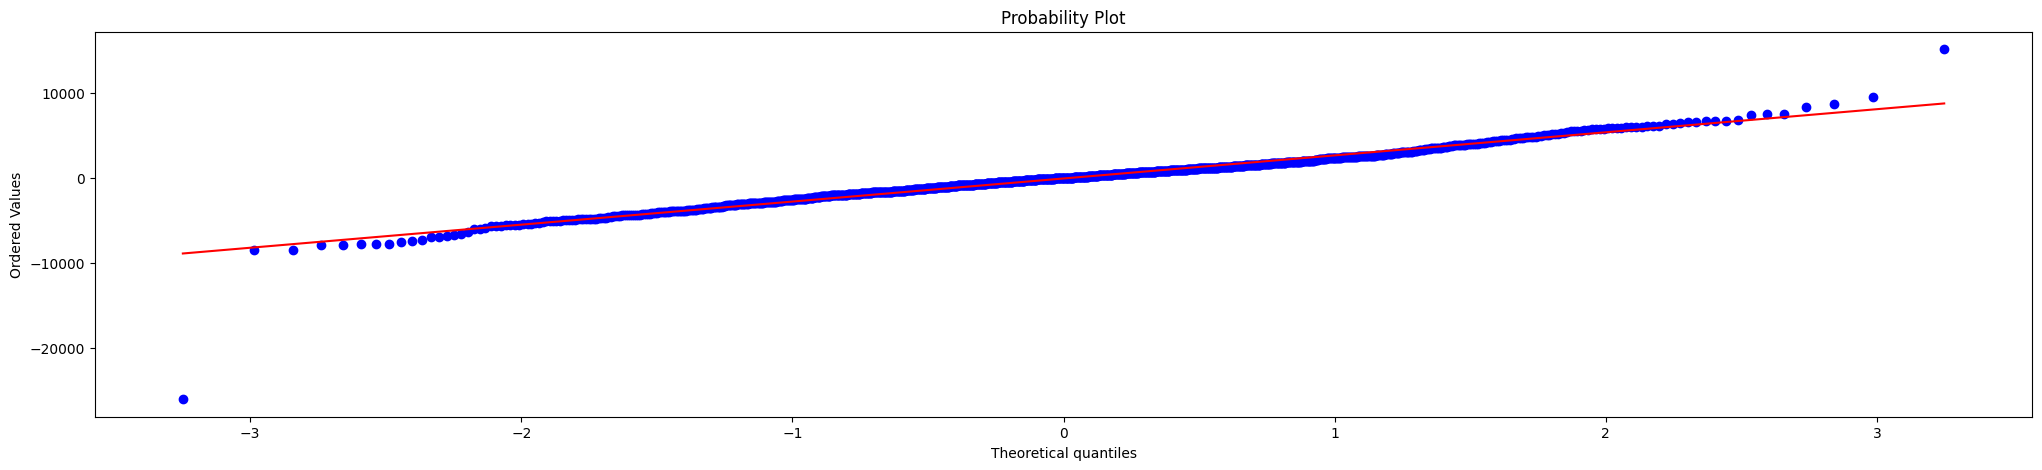

In [28]:
# Normaliry test
# H0: residuals are normally distributed
print(stats.normaltest(arima_best.resid))

plt.figure(figsize=[25,5])
res = stats.probplot(arima_best.resid, dist="norm", plot = plt)

Both normality test and Q-Q plot show that the residuals are not normally distributed.

Analysis of p-values for regressors:
* "Sunday" and "Temp3_South_Less" have really low p-value so they are definitely significant and should be kept;
* "Temp3_South_Gr" has p-value greater than the critical level of 0.05, but in general it is not that big so we can also keep it having in mind that this feature is dual to "Temp3_South_Less" (i.e. "is greater" and "is less" respectively);
* other features have p-values large than 0.3 and can be removed as non-significant.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                                      SARIMAX Results                                      
Dep. Variable:                   EnergyConsumption   No. Observations:                 1202
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 7)   Log Likelihood              -11182.121
Date:                             Wed, 26 Feb 2025   AIC                          22382.243
Time:                                     01:39:54   BIC                          22428.008
Sample:                                 01-01-2011   HQIC                         22399.486
                                      - 04-16-2014                                         
Covariance Type:                               opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Sunday           -6312.0391    250.763    -25.171      0.000   -6803.526   -5820.552
Temp3_Sou

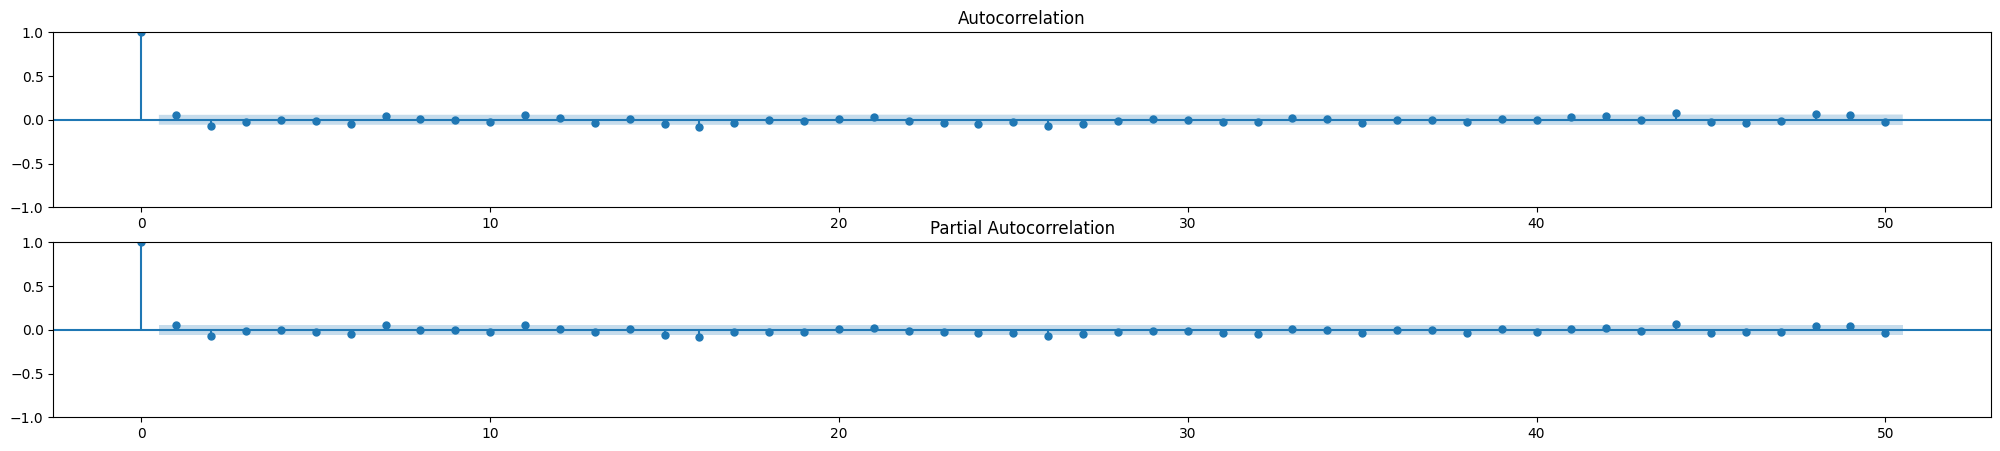

In [ ]:
# Rebuild best model excluding insignificant regressors
# Use data differentiated w.r.t. yearly seasonality as SARIMAX can handle only 1 period
ts_sdiff_1 = ts_sdiff[:-len(ts2)]
endog = ts_sdiff_1['EnergyConsumption']
exogs = ts_sdiff_1[['Sunday', 'Temp3_South_Less', 'Temp3_South_Gr']]
arima_best = sm.tsa.SARIMAX(endog=endog, order=[(1,2),1,(1,2)], seasonal_order=[0,1,1,7], exog=exogs).fit()
print(arima_best.summary())
plot_acf_pacf(arima_best, lags=50)

Let's build predictions for the training set and the forecast for the test set.

In [37]:
ts_sdiff_1.tail()

,EnergyConsumption,Saturday,Sunday,Temp1_South_Less,Temp2_South_Less,Temp3_South_Less,Temp4_South_Less,Temp1_South_Gr,Temp2_South_Gr,Temp3_South_Gr,Temp4_South_Gr
Date,,,,,,,,,,,
2014-04-12,-2861.397,1.0,0.0,4.5,5.8,2.3,-3.5,0.0,0.0,0.0,0.0
2014-04-13,4272.418,-1.0,1.0,3.0,2.6,-0.2,-4.5,0.0,0.0,0.0,0.0
2014-04-14,13921.481,0.0,-1.0,-2.5,0.5,-1.7,0.5,0.0,0.0,0.0,0.0
2014-04-15,5701.328,0.0,0.0,-5.0,-1.1,-2.2,1.0,0.0,0.0,0.0,0.0
2014-04-16,2853.131,0.0,0.0,-1.0,-1.0,2.1,5.0,0.0,0.0,0.0,0.0


In [31]:
# Draw prediction
start = '2012-01-01'
end = '2014-04-01'
draw_arima_forecast(ts_sdiff_1[['EnergyConsumption']], arima_best, start_dt=start, end_dt=end)

# ts_pred = arima_best.get_prediction()
# ts_pred_ci = ts_pred.conf_int()

In [32]:
# Build forecast
exog_columns = ['Sunday', 'Temp3_South_Less', 'Temp3_South_Gr']
ts_sdiff_2 = ts_sdiff[-len(ts2):] # prepare
exogs = ts_sdiff_2[exog_columns] # exogeneous variables future variables
ts_frc = arima_best.forecast(steps=len(ts_sdiff_2), exog=exogs)
ts_frc_int = (ts_frc + ts.shift(365)['EnergyConsumption']).iloc[-len(ts2):] # integration with 365

In [33]:
# Plot the TS together with independent variables
ts_to_plot = ts.iloc[-len(ts2):]

# setting of the plotting style, registers pandas date converters for matplotlib and the default figure size
fig = go.Figure()
fig.add_trace(go.Scatter(x=ts_to_plot['EnergyConsumption'].index,
                        y=ts_to_plot['EnergyConsumption']
                        , name="EnergyConsumption"))

fig.add_trace(go.Scatter(x=ts_to_plot['EnergyConsumption'].index,
                        y=ts_frc_int
                        , name="arima best forecast"))

fig.add_trace(go.Scatter(x=ts_to_plot['EnergyConsumption'].index,
                        y=ts_to_plot[['Sunday']].max(axis=1).replace(0, np.NaN)
                        , name="Saturday and Sunday", yaxis="y2"))
fig.add_trace(
    go.Scatter(x=ts_to_plot['EnergyConsumption'].index,
                        y=ts_to_plot['Temp3_South_Less']
                        , name="Temp", yaxis="y3"))
fig.add_trace(
    go.Scatter(x=ts_to_plot['EnergyConsumption'].index,
                        y=ts_to_plot['Temp3_South_Gr']
                        , name="Temp", yaxis="y3"))

fig.update_layout(
    xaxis=dict(domain=[0.1, 0.95]),
    yaxis=dict(
        title="EnergyConsump",
    ),
    yaxis2=dict(
        title="Holidays",
        overlaying="y",
        side="right",
    ),
    yaxis3=dict(title="Temp", anchor="free", overlaying="y", autoshift=True),
)

fig.update_layout(height=500, width=1300).show()

In [ ]:
# MAPE for the whole forecasting period
qualityMAPE(ts2['EnergyConsumption'], ts_frc_int)[0]

0.12769868443940674

In [ ]:
# MAPE for the first 3 months of the forecasting period
qualityMAPE(ts2['EnergyConsumption'][:'2014-07-15'], ts_frc_int[:'2014-07-15'])[0]

0.037558449874769126

The forecast looks more or less appropriate only for the first 3 months. Further it seems that the model can't predict the right (probably non-linear) trend as the forecast shape looks appropriate in general but biased w.r.t. actual values. Also, MAPE looks not so good being around 10%.

# Internal Functional for Regression TS Models
## ML approach to the problem (reminder)

* Definitions
  * $X$ --- feature space ($\mathbb R^n$);
  * $Y$ --- answer space ($\mathbb R$);
  * $X^\ell = (x_i,y_i)_{i=1}^\ell~-$ train samples;
  * $y_i=y(x_i)$,$~y\colon X\to Y~-$ unknown function;

  * assumption: there is joint distribution $p(x,y)$ for samples from $X^\ell$
  * loss function $\lambda(y_i, \hat y_i): \mathbb R\times \mathbb R\rightarrow [0,+\infty) $

* Learning method is a function: $\mu\colon 2^{X\times Y}\rightarrow \mathfrak{A}$

* loss of algorithm $A=\mu(X^\ell)$:
$$  {Loss}_A = {\mathbf E}_{x,y}\left[ \lambda\left(y, \mu\left(X^\ell\right)\right)\right]$$
  * Estimation of algorithm loss $A=\mu(X^\ell)$

$$ Loss_{A}(X^\ell)=\sum_{i=1}^\ell \lambda\left(y_i, A(x_i)\right) $$

* loss of learning method $\mu$:
$$ {Q}_\mu={\mathbf E}_{X^\ell}\left[Loss_{A} \right] $$

* <font color="red">Main problem of ML is to minimize ${Q}_\mu$</font>

**Question:**
  * Which approaches do you know to calculate ${Q}_\mu$?
<br></br>
<br></br>

## Estimation of $Q_\mu$ using CV

* Hold-out CV: split all data to two sets: $X^\ell=X^{Train}\bigcup X^{Validation}$
<img src = "https://algotrading101.com/learn/wp-content/uploads/2020/06/training-validation-test-data-set.png">


$$ Q_\mu^{CV} (X^\ell) = Q\left(\mu(X^L),X^K\right) = Loss_{\mu(X^L)}\left(X^{K} \right)
$$

**Question**: why testing sample is needed?

<br></br>
* q-fold CV: $X^\ell=X_1^{\ell_1}\bigcup\dots\bigcup X_q^{\ell_q}$

<img src = "https://sebastianraschka.com/images/faq/evaluate-a-model/nested-k-fold.png">
$$
            \mathrm{Q_\mu^{q-fold}}(X^\ell)
            =\frac{1}{q}
            \sum_{i=1}^q
                Q \bigl(\mu \left(X^\ell\!\setminus\!\!\{X^{\ell_i}_i\}\right), X^{\ell_i}_i \bigr)
$$



## Estimation of $Q_\mu$ in case of Linear Regression
* Let's assume that
$$\mu(X^\ell)(x_i) = A(x_i) = f_1(x_i)\cdot w_1 + \dots + f_\color{red}d (x_i)\cdot w_\color{red}d$$

* Calculate loss of the learning algorithm on the whole $X^\ell$

$$Q \bigl(\mu \left(X^\ell\right), X^{\ell} \bigr) =\log\left(\frac{1}{\ell}{\sum_{i=1}^\ell \left(\mu(X^\ell)(x_i) - y_i\right)^2}\right)$$

<!-- i.e. just log(MSE) -->
<!--
<table border="0">
 <tr>
    <td><style="font-size:30px">
      Criterion
    </td>
    <td>
      $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ML Equivalence Formula$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$
    </td>
    <td>
      $~~~~~~$Pro
    </td>
</tr>
<tr>
    <td>
AIC (Akaike Information Criterion)
    </td>
    <td>  
      $$Q_\mu^{AIC}(X^\ell) = Q \bigl(\mu \left(X^\ell\right), X^{\ell} \bigr)+ \frac{2\cdot d }{\ell}$$
    </td>
    <td>
  - model has unknown high dimensional reality
  <br></br>
  - asymptotically efficient (is good for making asymptotically equivalent to cross-validation)
    </td>
</tr>
<tr>
</td>
    <td>
BIC (Bayes Information Criterion)
</td>
    <td>
$$Q_\mu^{BIC}(X^\ell) =  Q \bigl(\mu \left(X^\ell\right), X^{\ell} \bigr) + \frac{\ln(\ell)\cdot d}{\ell}$$
</td>
    <td>
     - penalizes free parameters more strongly than AIC
     <br></br>
     - is consistent
</tr>
<tr>
  <td>
HQIC (Hannan–Quinn information criterion)
</td>
    <td>
    $$Q_\mu^{HQIC}(X^\ell) = Q \bigl(\mu \left(X^\ell\right), X^{\ell} \bigr) + \frac{\ln\ln(\ell)\cdot d}{\ell}$$
  </td>
  <td>
     - is consistent
     <br></br>
     - asymptotically very well-behaved
  </td>
</tr>
</table> -->


| | Criterion | ML Equivalence Formula    | Pro   |
|---:|:-------------|:-----------|:------|
| 1 | AIC (Akaike Information Criterion)  | $$Q_\mu^{AIC}(X^\ell) = Q \bigl(\mu \left(X^\ell\right), X^{\ell} \bigr)+ \frac{2\cdot d }{\ell}$$       | - model has unknown high dimensional reality <br></br>- asymptotically efficient (is good for making asymptotically equivalent to cross-validation)   |
| 2 | BIC (Bayes Information Criterion)  | $$Q_\mu^{BIC}(X^\ell) =  Q \bigl(\mu \left(X^\ell\right), X^{\ell} \bigr) + \frac{\ln(\ell)\cdot d}{\ell}$$    | - penalizes free parameters more strongly than AIC <br></br>- is consistent   |
| 3 | HQIC (Hannan–Quinn information criterion)	  | $$Q_\mu^{HQIC}(X^\ell) = Q \bigl(\mu \left(X^\ell\right), X^{\ell} \bigr) + \frac{\ln\ln(\ell)\cdot d}{\ell}$$    | - is consistent <br></br>- asymptotically very well-behaved   |

# Conclusion
## Approach how to fit ARIMA

<img src = 'https://www.autobox.com/cms/images/easyblog_images/64/arimaredo.png'>


**Materials**
* Автокорреляционный анализ при построении ARMA, ARIMA
    - Магнус Я.Р., Катышев П.К., Пересецкий А.А. Эконометрика. Начальный курс., глава 11
    - http://www.autobox.com/cms/index.php/blog/entry/build-or-make-your-own-arima-forecasting-model

* Autocorrelation analysis

  - https://online.stat.psu.edu/stat510/lesson/2

  - http://www.autobox.com/cms/index.php/blog/entry/build-or-make-your-own-arima-forecasting-model

* Difference Between AIC and BIC | Difference Between http://www.differencebetween.net/miscellaneous/difference-between-aic-and-bic/#ixzz79MzuB0pt
* AIC, BIC derivation http://faculty.washington.edu/yenchic/19A_stat535/Lec7_model.pdf